In [5]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil
import sys
sys.path.append("..")

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from PJT_Frustration_Induced_Crystallize.main import *
from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#FF0000"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

SAVE_PATH = r"F:\MS_ExperimentData\general"
MP4_PATH = r"F:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"

# Single cell trajectory

In [4]:
reduceModel = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    # initPhaseTheta=np.zeros(1000), 
    omegaMin=0, deltaOmega=0,
    agentsNum=102, dt=0.001,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=1, 
    randomSeed=9, overWrite=False
)
sa = StateAnalysis(reduceModel)

(4.0, 6.0)

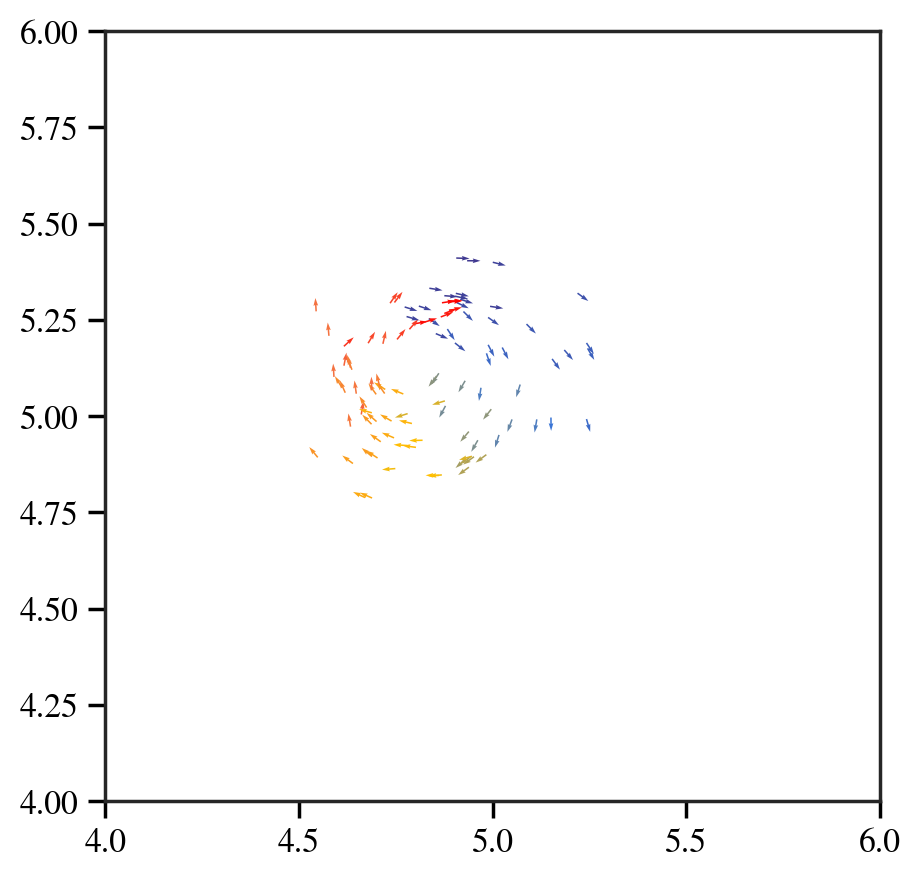

In [13]:
sa.plot_spatial(colorsBy="phase")
plt.xlim(4, 6)
plt.ylim(4, 6)

In [18]:
sa.totalPositionX.shape

(10000, 102, 2)

(4.0, 6.0)

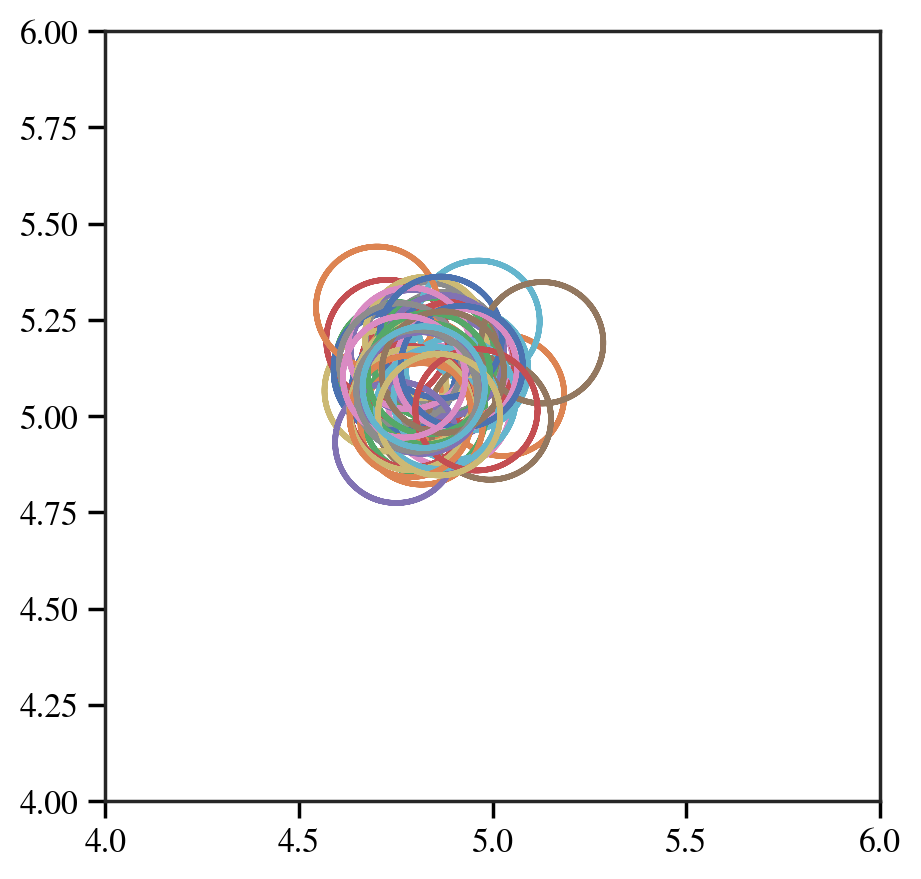

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

timeCounts = 1000
# trajectoryColors = ["#3A76D6", "#F46F43", "#FF0000", "#403990", "#FFC001"]
# for i, singleSelectIdx in enumerate([0, 5, 13, 75, 80]):
for i, singleSelectIdx in enumerate(range(50)):
    ax.plot(
        sa.totalPositionX[-timeCounts:, singleSelectIdx, 0],
        sa.totalPositionX[-timeCounts:, singleSelectIdx, 1],
        # color=trajectoryColors[i], 
        alpha=1, lw=2, zorder=0
    )

plt.xlim(4, 6)
plt.ylim(4, 6)

# Multi cells breathe sync

In [4]:
model = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    # initPhaseTheta=np.zeros(1000), 
    omegaMin=0, deltaOmega=0,
    agentsNum=3000, dt=0.005,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=1, 
    randomSeed=10, overWrite=False
)
sa = StateAnalysis(model)

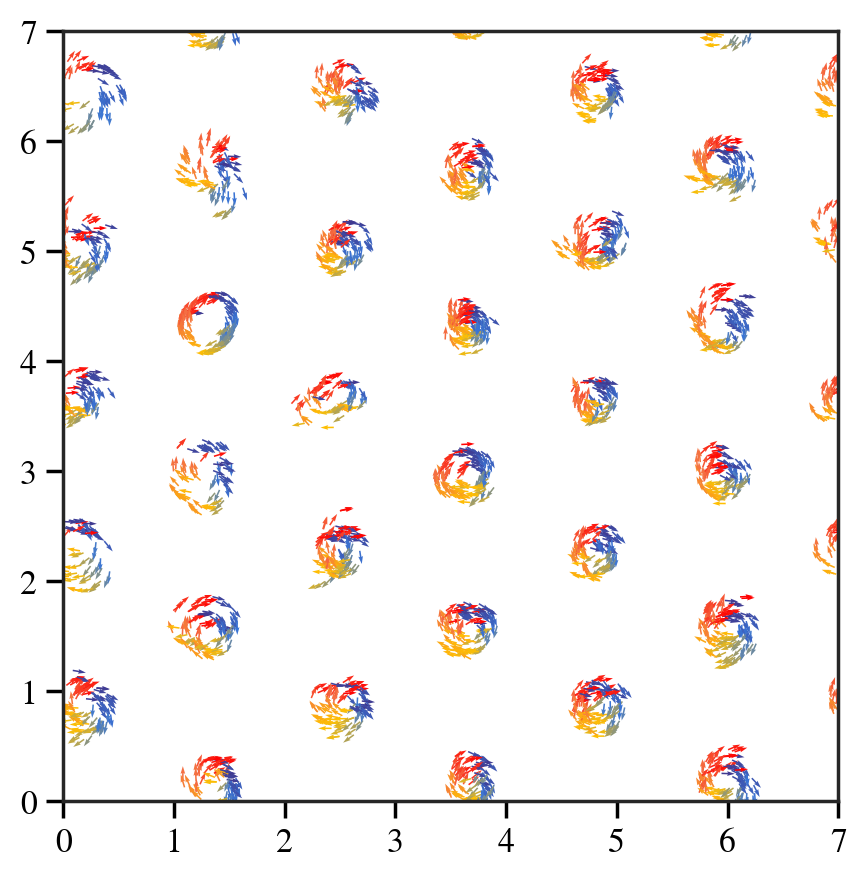

In [6]:
sa.plot_spatial(colorsBy="phase")

In [7]:
shift = np.array([0., 0.])

classes, centers = sa.calc_classes_and_centers(classDistance=0.5, lookIdx=-1)
centers = np.mod(centers + shift, model.boundaryLength)

classCenters: List[np.ndarray] = []
for c in classes:
    singleClassCenters = centers[c]

    maxDeltaX = np.abs(singleClassCenters[:, 0] - singleClassCenters[:, 0, np.newaxis]).max()
    subXShift = model.halfBoundaryLength if maxDeltaX > model.halfBoundaryLength else 0
    maxDeltaY = np.abs(singleClassCenters[:, 1] - singleClassCenters[:, 1, np.newaxis]).max()
    subYShift = model.halfBoundaryLength if maxDeltaY > model.halfBoundaryLength else 0

    singleClassCenters = np.mod(singleClassCenters - np.array([subXShift, subYShift]), model.boundaryLength)
    classCenter = np.mod(singleClassCenters.mean(axis=0) + np.array([subXShift, subYShift]), model.boundaryLength)
    classCenters.append(classCenter)
classCenters: np.ndarray = np.array(classCenters)

edgeLenThres = (
    model.distanceD0 + 
    2 * model.speedV / np.abs(model.freqOmega - model.strengthK * np.sin(model.phaseLagA0)).min()
) * 1.2
edges, ajdClassCenters = sa.calc_nearby_edges(classCenters=classCenters, stdMulti=0.3)

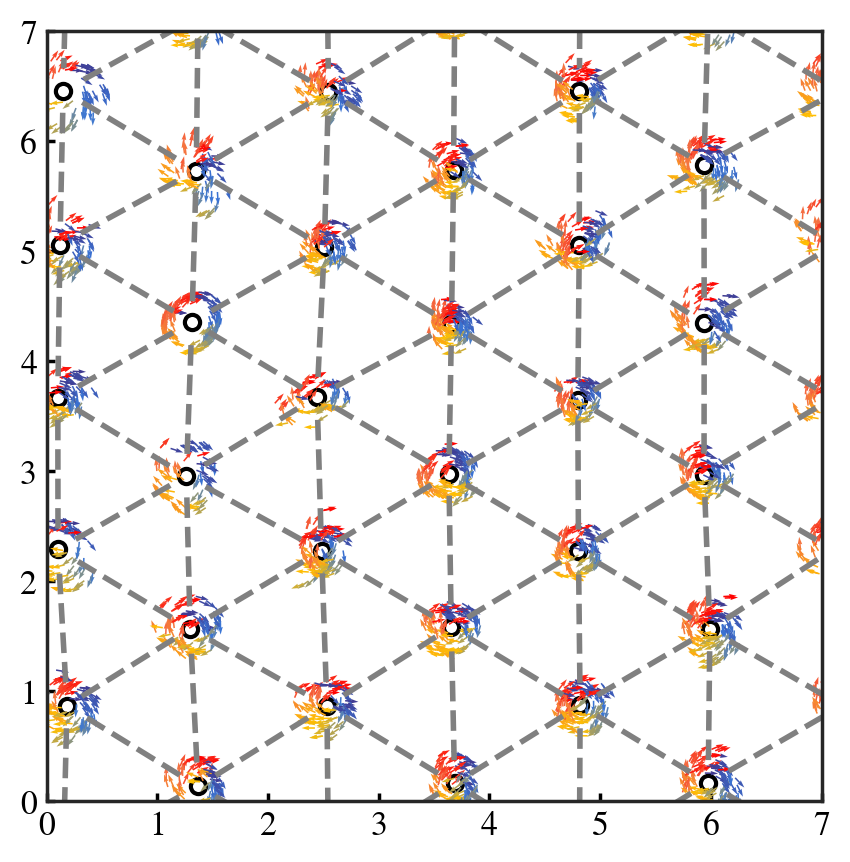

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(
    classCenters[:, 0], classCenters[:, 1],
    facecolor="white", s=30, edgecolor="black", lw=1.5
)

for edge in edges[:]:
    # plt.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1],
    #          color="black", lw=1.2, alpha=0.3, linestyle=(0, (10, 2)), zorder=0)
    edgeCenter = (ajdClassCenters[edge[0]] + ajdClassCenters[edge[1]]) / 2
    edgeNodesDelta = ajdClassCenters[edge[0]] - ajdClassCenters[edge[1]]
    edgeAngle = np.arctan2(edgeNodesDelta[1], edgeNodesDelta[0])
    edgeShift = np.array([np.cos(edgeAngle), np.sin(edgeAngle)]) * 0.5 * model.distanceD0

    plt.plot([edgeCenter[0] - edgeShift[0], edgeCenter[0] + edgeShift[0]], 
             [edgeCenter[1] - edgeShift[1], edgeCenter[1] + edgeShift[1]],
             lw=2, alpha=1, color="gray", ls="--")

analRadius = model.distanceD0 + 2 * model.speedV / np.abs(model.strengthK * np.sin(model.phaseLagA0))

for classCenter in classCenters:
    circle = plt.Circle(
        classCenter, analRadius, color="black", fill=False, lw=2, alpha=1, ls="--"
    )
    # ax.add_artist(circle)

sa.plot_spatial(ax=ax, colorsBy="phase", index=-1, shift=shift)

plt.tick_params(length=3, direction="in")

In [62]:
totalTvRadius = list()
step = 1

for idx, singleClass in enumerate(classes):
    subPositionX = sa.totalPositionX[::step, singleClass, :]
    classCenter = classCenters[idx]
    tvMaxRadius = sa.calc_replative_distance(subPositionX, classCenter).mean(axis=1)
    totalTvRadius.append(tvMaxRadius)

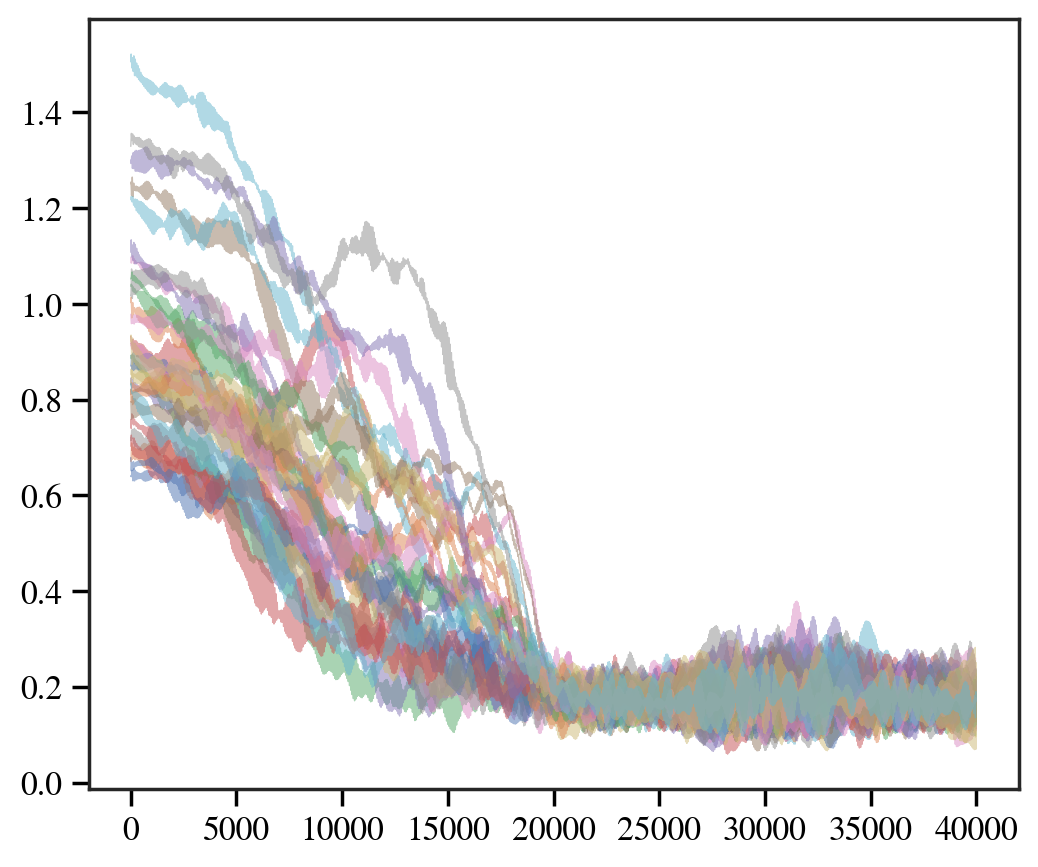

In [63]:
for tvRadius in totalTvRadius:
    plt.plot(tvRadius, alpha=0.5, lw=0.5)

(0.05, 0.3)

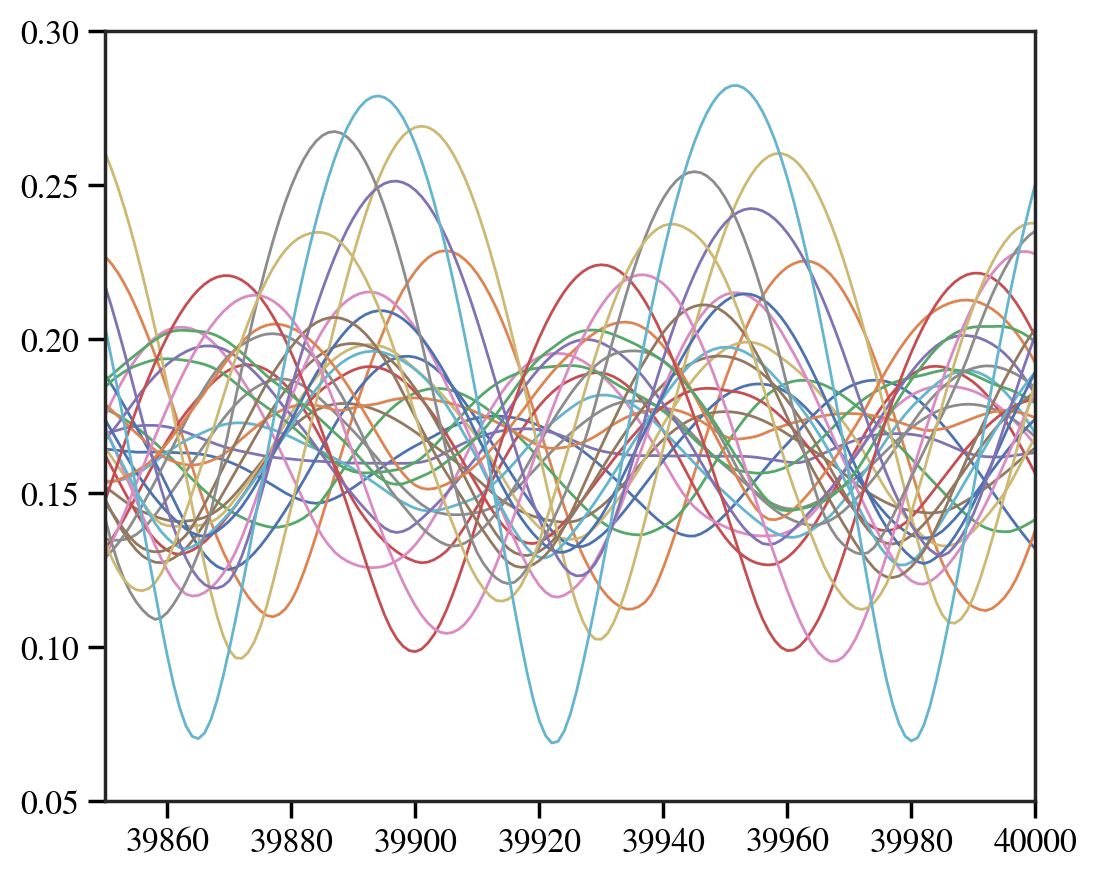

In [65]:
sortedTotalTvRadius = sorted(totalTvRadius, key=lambda x: x[-1])

for tvRadius in sortedTotalTvRadius:
    plt.plot(tvRadius, lw=1)

plt.xlim(7970 * 5, 8000 * 5)
plt.ylim(0.05, 0.3)

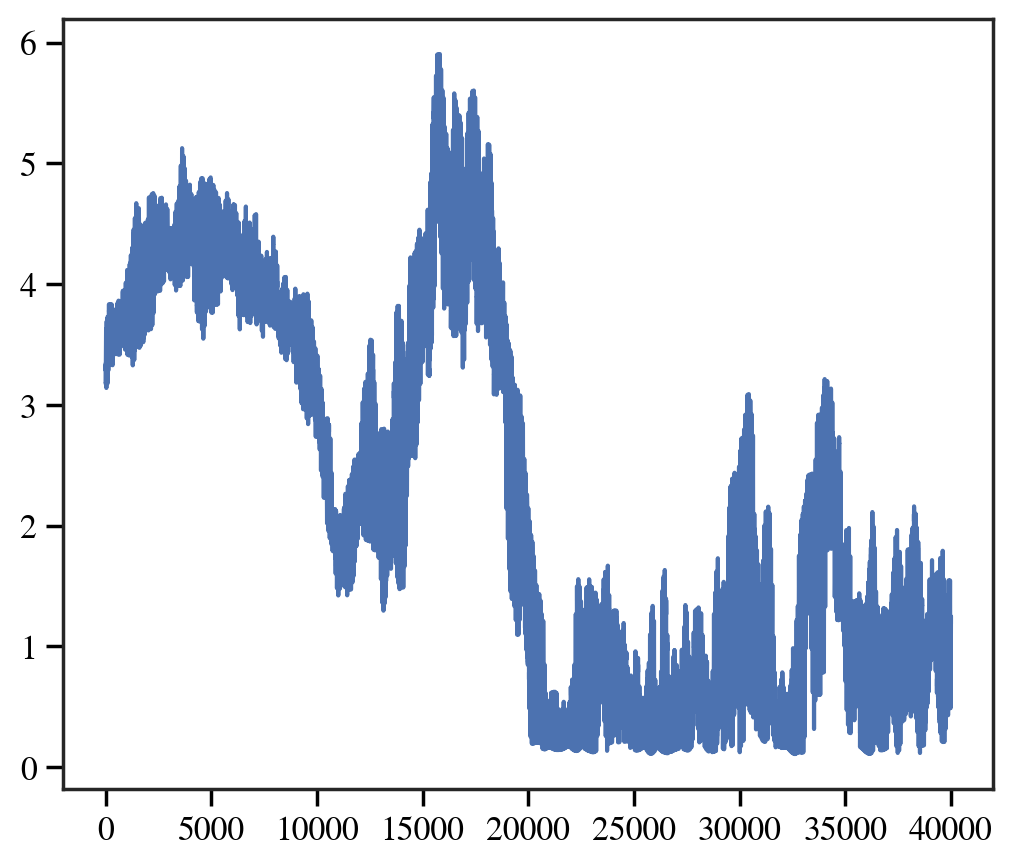

In [20]:
plt.plot(np.linalg.norm(subPositionX - classCenter, axis=-1).mean(axis=1))

In [2]:
cellModel = CellAndSingleParticle(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    omegaMin=0, deltaOmega=0,
    agentsNum=100, dt=0.001,
    singleParticleDis=0.2, singleParticlePhase=0,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=5, 
    randomSeed=randomSeed, overWrite=False
)
cellModel.run(1000)
sa = StateAnalysis(cellModel)

F:\MS_ExperimentData\general/CellAndSingleParticle(strengthK=20.000,distanceD0=1.000,phaseLagA0=1.885,sPD=0.200,sPP=0.000,boundaryLength=7.0,speedV=3.0,omegaMin=0.000,deltaOmega=0.000,agentsNum=100,dt=0.001,shotsnaps=5,randomSeed=10).h5 already exists, but has only 201 snapshots, will continue to run until 202 snapshots.


  0%|          | 0/4 [00:00<?, ?it/s]

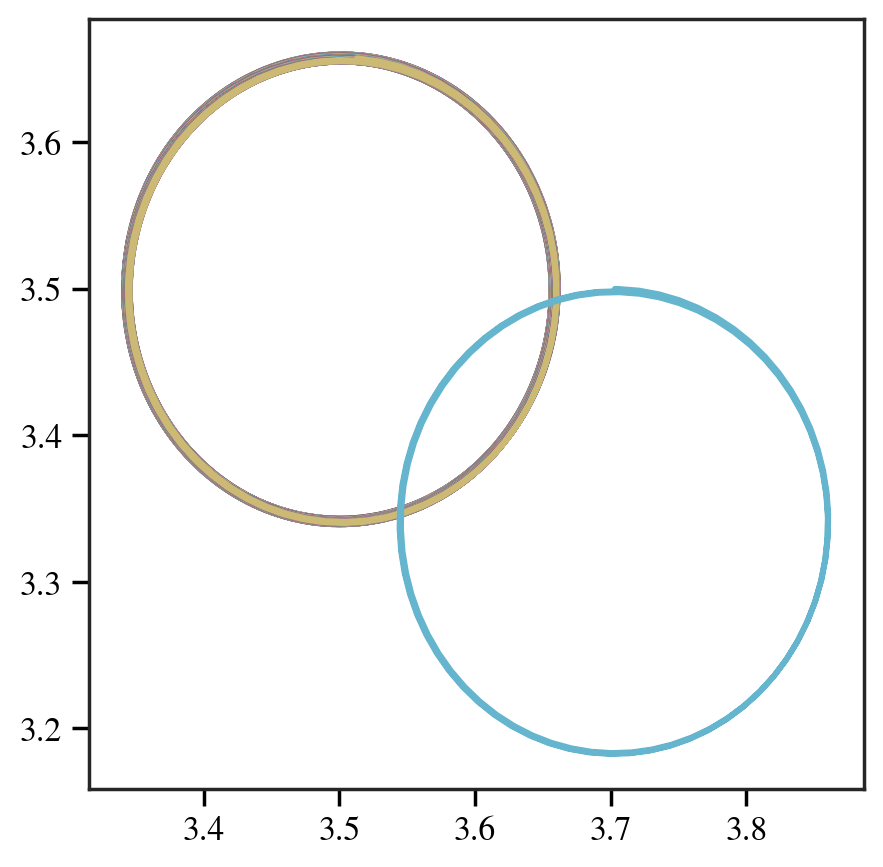

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))

timeCounts = 1000
# trajectoryColors = ["#3A76D6", "#F46F43", "#FF0000", "#403990", "#FFC001"]
# for i, singleSelectIdx in enumerate([0, 5, 13, 75, 80]):
for i, singleSelectIdx in enumerate(range(cellModel.agentsNum)):
    ax.plot(
        sa.totalPositionX[-timeCounts:, singleSelectIdx, 0],
        sa.totalPositionX[-timeCounts:, singleSelectIdx, 1],
        # color=trajectoryColors[i], 
        alpha=1, lw=2, zorder=0
    )

# plt.xlim(4, 6)
# plt.ylim(4, 6)

In [104]:
strengthK = 20
distanceD0 = 1
phaseLagA0 = 0.6 * np.pi
speedV = 3
singleParticleDiss = np.linspace(0.1, distanceD0 + speedV / np.abs(strengthK * np.sin(phaseLagA0)), 11)[::2]
singleParticleAngles = np.linspace(-np.pi / 2, np.pi / 2, 11)[::]

models = [
    CellAndSingleParticle(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLagA0,
        singleParticleDis=singleParticleDis, singleParticleAngle=singleParticleAngle,
        agentsNum=100, dt=0.001,
        tqdm=False, savePath=SAVE_PATH, shotsnaps=5, 
        randomSeed=randomSeed, overWrite=False
    )
    for singleParticleDis in singleParticleDiss
    for singleParticleAngle in singleParticleAngles
]

(2.0, 5.0)

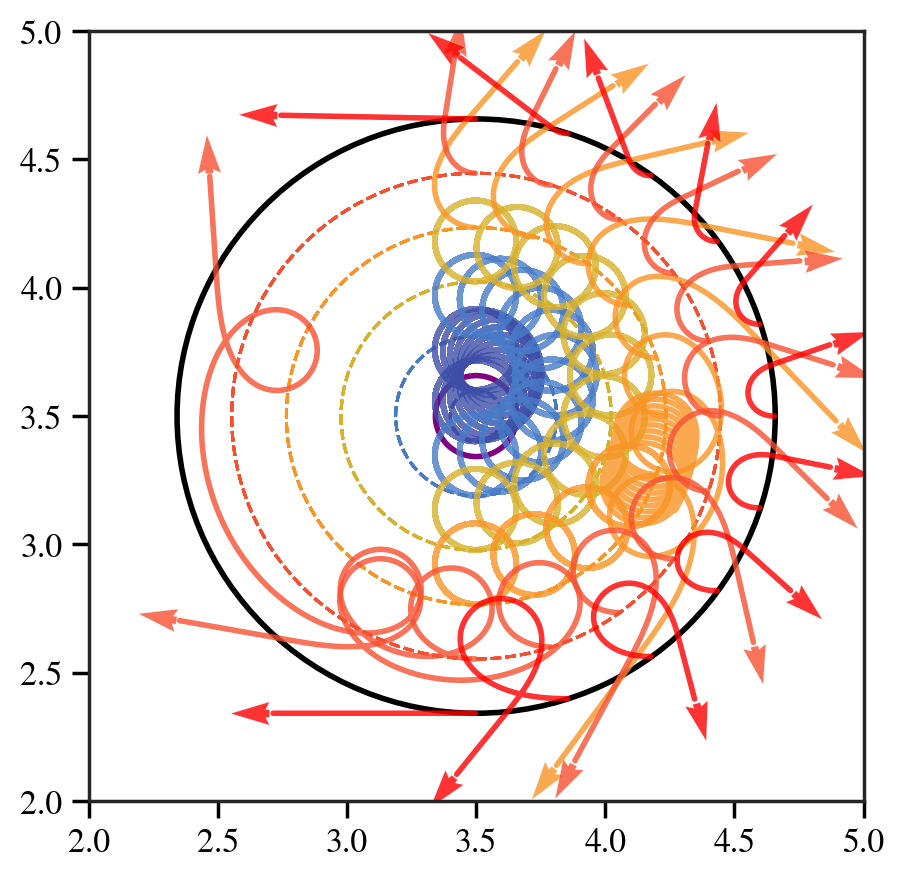

In [109]:
fig, ax = plt.subplots(figsize=(5, 5))
# model.plot(ax=ax, colorsBy="phase")
boxCenter = np.array([3.5, 3.5])
disThres = 1.4
analRadius = model.speedV / np.abs(model.strengthK * np.sin(model.phaseLagA0))

for model in models[:]:

    sa = StateAnalysis(model)    
    sinParPos = sa.totalPositionX[:, -1]
    sinParPha = sa.totalPhaseTheta[:, -1]

    alpha = 0.8
    # alpha = 1 - (model.singleParticleDis / singleParticleDiss.max()) * 0.5
    # color = "C2"
    color = cmap(model.singleParticleDis / singleParticleDiss.max())

    circle = plt.Circle(boxCenter, model.singleParticleDis, color=color, 
                    fill=False, lw=1, alpha=1, ls="--")
    ax.add_artist(circle)

    centerDis = sa.calc_replative_distance(sinParPos, boxCenter)
    breakThres = np.where(centerDis > disThres)[0]
    if len(breakThres) == 0:
        plt.plot(sinParPos[:, 0], sinParPos[:, 1], color=color, lw=2, alpha=alpha)
        continue

    firstBreakThres = np.where(centerDis > disThres)[0][0]
    plt.plot(sinParPos[:firstBreakThres, 0], sinParPos[:firstBreakThres, 1], color=color, lw=2, alpha=alpha)
    plt.quiver(
        sinParPos[firstBreakThres, 0], sinParPos[firstBreakThres, 1],
        np.cos(sinParPha[firstBreakThres]), np.sin(sinParPha[firstBreakThres]),
        color=color, lw=0.1, alpha=alpha, width=0.02, scale=20
    )
    

# plt.quiver(model.positionX[:-1, 0], model.positionX[:-1, 1],
#            np.cos(model.phaseTheta[:-1]), np.sin(model.phaseTheta[:-1]),)
circle = plt.Circle(boxCenter, analRadius, color="purple", 
                    fill=False, lw=2, alpha=1, ls="-")
ax.add_artist(circle)
circle = plt.Circle(boxCenter, model.distanceD0 + analRadius, color="black", 
                    fill=False, lw=2, alpha=1, ls="-")
ax.add_artist(circle)
plt.ylim(2, 5)
plt.xlim(2, 5)
# plt.xlim(0, sa.totalPositionX.shape[0])

In [10]:
import numpy as np
from scipy.special import j1

def theta_k(k, d0):
    """
    计算积分 Θ_k = ∫ d²R Θ(d0 - |R|) exp(i k·R)
    
    参数:
        k (ndarray): 波矢 [kx, ky]，或标量 k = |k|
        d0 (float): 截断半径
        
    返回:
        complex: 积分结果 (实数)
    """
    # 计算 |k|
    if isinstance(k, (list, np.ndarray)):
        k_norm = np.linalg.norm(k)
    else:
        k_norm = k  # 若 k 是标量，直接使用
        
    if k_norm == 0:
        return np.pi * d0**2
    else:
        return (2 * np.pi * d0 / k_norm) * j1(k_norm * d0)

d0 = 1.0  # 阶跃距离
k_norm = 2.0  # 波数模长，或使用 k_vector = (1.0, 1.0)

result = theta_k(k_norm, d0)
print(f"积分结果: {result:.6f}")

积分结果: 1.811834


In [13]:
theta0 = theta_k(0, d0)

def lambda_m(k: float | List | np.ndarray, d0: float, K: float, alpha: float):
    thetaK = theta_k(k, d0)
    return K * thetaK / (theta0 * 2) * np.cos(alpha)

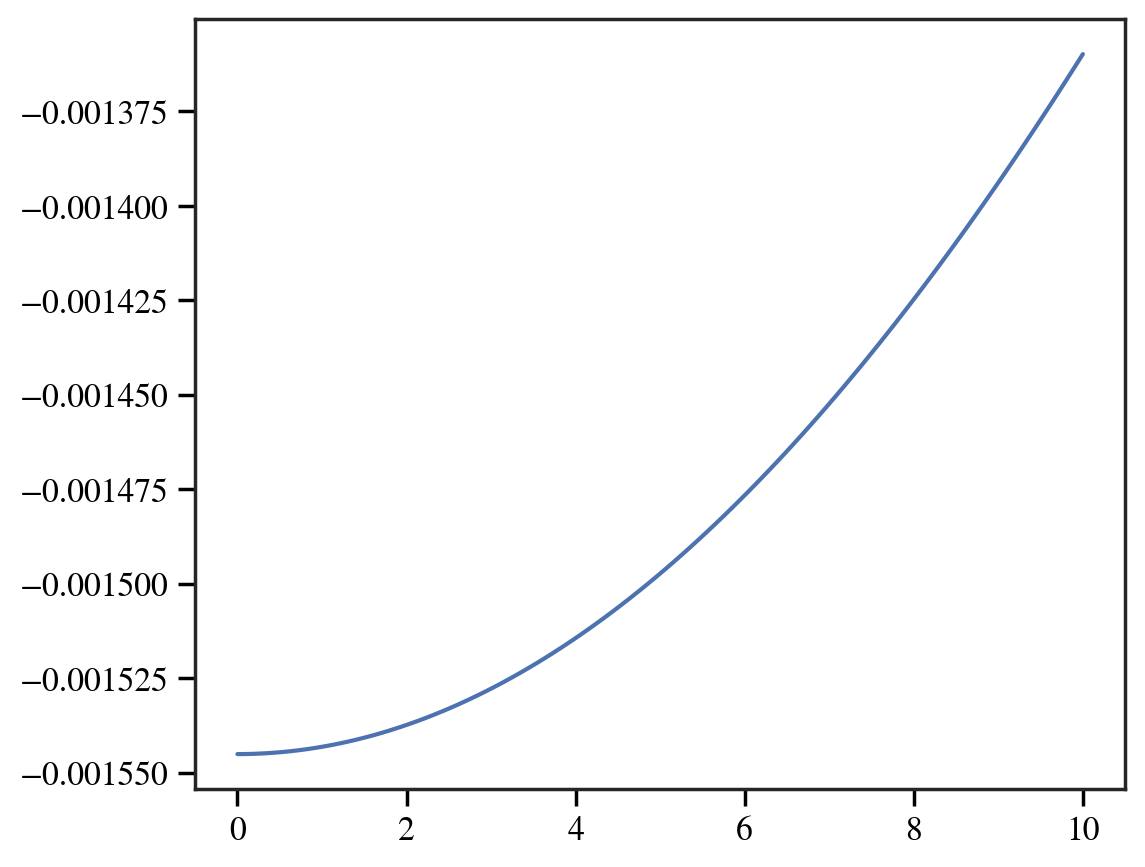

In [24]:

kNorms = np.linspace(0., 10, 100)
lambda_ms = np.array([
    lambda_m(kNorm, d0=0.1, K=1, alpha=0.6 * np.pi) 
    for kNorm in kNorms
])

plt.plot(kNorms, lambda_ms)

In [20]:
kNorms[np.where(lambda_ms > 0)[0][0]]

3.8383838383838382